In [1]:
include("notebook_preamble.jl");

In [2]:
using SymPy;
include("TransverseIsingModels.jl")
using .TransverseIsingModels
TIM = TransverseIsingModels;

In [3]:
⊗ₖ = kron;
const σ0 = [1 0; 0 1];
const σx = [0 1; 1 0];
const σy = [0 -im; im 0];
const σz = [1 0; 0 -1];
const σp = [0 1; 0 0];
const σm = [0 0; 1 0];

# Computation of jump operators

In [4]:
function symeigen(H)
    symeig = H.eigenvects()
    vals, vecs = eltype(H)[], []
    for (λ, _, vs) in symeig
        for v in vs
            push!(vals, λ)
            push!(vecs, vec(v))
        end
    end
    vals, vecs
end;

In [5]:
function addentry!(dict, key, value; isequal=isequal)
    for k in keys(dict)
        if isequal(k, key)
            push!(dict[k], value)
            return dict
        end
    end
    dict[key] = [value]
    dict
end;

In [6]:
firstvalue(i, (x, y)) = x
lastvalue(i, (x, y)) = y
function dictby(A; isequal=isequal, keyof=firstvalue, valof=lastvalue)
    i0, x0 = 1, first(A)
    k0, v0 = keyof(i0, x0), valof(i0, x0)
    dict = Dict(k0 => typeof(v0)[])
    dict = Dict()
    for (i, x) in enumerate(A)
        k, v = keyof(i, x), valof(i, x)
        addentry!(dict, k, v, isequal=isequal)
    end
    dict
end;

In [7]:
import QuantumOpticsBase.projector
projector(ψ::AbstractVector) = ψ * ψ';

In [8]:
function incentry!(dict, key; isequal=isequal)
    for k in keys(dict)
        if isequal(k, key)
            dict[k] += 1
            return dict
        end
    end
    dict[key] = 1
    dict
end;

In [9]:
function combinejumps(Js)
    d = Dict()
    for J in Js
        incentry!(d, J)
    end
    [√(one(eltype(J)) * N)*J for (J, N) in d]
end;

In [10]:
function jumps(vals, vecs, As; combine=true, isequal=isequal)
    eigendict = dictby(zip(vals, vecs))
    ωs = dictby(((E2 - E1, (E1, E2)) for E1 in keys(eigendict) for E2 in keys(eigendict)), isequal=isequal)
    Πs = TIM.projectors(eigendict)
    Jωs = dictmap(ΔEs -> filter(x -> !isequal(x, zero(x)), [simplify.(sum(Πs[E1]*A*Πs[E2] for (E1, E2) in ΔEs)) for A in As]), ωs)
    combine ? dictmap(combinejumps, Jωs) : Jωs
end
dipolejumps(vals, vecs; kwargs...) = jumps(vals, vecs,
    [σx ⊗ₖ σ0,  σy ⊗ₖ σ0,  σz ⊗ₖ σ0, σ0 ⊗ₖ σx,  σ0 ⊗ₖ σy,  σ0 ⊗ₖ σz];
    kwargs...);

In [11]:
@vars s1p=>"σ₁⁺" s1m=>"σ₁⁻" commutative=false
@vars s2p=>"σ₂⁺" s2m=>"σ₂⁻" commutative=false
@vars s1x=>"σ₁ˣ" s2x=>"σ₂ˣ" commutative=false
@vars s1y=>"σ₁ʸ" s2y=>"σ₂ʸ" commutative=false
@vars s1z=>"σ₁ᶻ" s2z=>"σ₂ᶻ" commutative=false
@vars n1 =>"n₁"   n2=>"n₂"  commutative=false
@vars g d real=true;

In [12]:
spinops = [s1p, s1m, s2p, s2m, s1x, s2x, s1y, s2y, s1z, s2z, n1, n2];
_symspinop = cat([n1 s1p; s1m (1 - n1)], [n2 s2p; s2m (1 - n2)], dims=3)
_dummy_spinop = Dict(s => sympy.Dummy(s.name) for s in spinops);
site_collect_ops(siteops) = push!([_dummy_spinop[op] for op in siteops], 1)
_collect_ops = [a * b for a in site_collect_ops([s1p, s1m, n1]) for b in site_collect_ops([s2p, s2m, n2])];

In [13]:
u, v, w = Wild(:u), Wild(:v), Wild(:w);

In [14]:
symspinop(l, r, i) = _symspinop[l+1, r+1, i];
function jumpsimplify(J)
    s = mapreduce(+, CartesianIndices(J)[J .!= 0]) do I
        x = J[I]
        i, j = Tuple(I - CartesianIndex(1, 1))
        x * symspinop(i÷2, j÷2, 1) * symspinop(i%2, j%2, 2)
    end
    s = subs(expand(s), √(g^2 + 1) => d)
    s = s.simplify()
    s = s.xreplace(_dummy_spinop)
    for op in _collect_ops
        s = s.collect(op)
    end
    s.simplify()
end;

In [15]:
=>ₛ(a, b) = _dummy_spinop[a] => b
thesis_latex(J) = sympy.latex(J,
        imaginary_unit = "\\im",
        symbol_names = Dict(
            g   =>  "g",
            d   =>  "d",
            n1  =>ₛ "\\opr{n}_1",
            n2  =>ₛ "\\opr{n}_2",
            s1p =>ₛ "\\pauli_1^+",
            s2p =>ₛ "\\pauli_2^+",
            s1m =>ₛ "\\pauli_1^-",
            s2m =>ₛ "\\pauli_2^-",
        ));

In [16]:
function save_jump_latex(path, sJωs)
    open(path, "w") do file
        for (ω, Js) in sJωs
            sω = factor(subs(expand(ω), √(g^2 + 1) => d))
            println(file, thesis_latex(sω))
            println(file, " \\\\")
            for J in Js
                println(file, thesis_latex(J))
                println(file, " \\\\")
            end
            println(file, " \\\\")
        end
    end
end;

## Nondegenerate jump operators

In [17]:
H = -2*(σx ⊗ₖ σx) - g*(σz ⊗ₖ σ0 + σ0 ⊗ₖ σz)

4×4 Array{Sym,2}:
 -2⋅g   0   0   -2
    0   0  -2    0
    0  -2   0    0
   -2   0   0  2⋅g

In [18]:
sJωs = dictmap(Js -> jumpsimplify.(Js), dipolejumps(symeigen(H)...; combine=true))
save_jump_latex("nondegen-jumps.tex", sJωs)

## Degenerate jump operators

In [19]:
H0 = subs.(-2*(σx ⊗ₖ σx) - g*(σz ⊗ₖ σ0 + σ0 ⊗ₖ σz), g => 0)

4×4 Array{Sym,2}:
  0   0   0  -2
  0   0  -2   0
  0  -2   0   0
 -2   0   0   0

In [20]:
sJωs0 = dictmap(Js -> jumpsimplify.(Js), dipolejumps(symeigen(H0)...; combine=true))
save_jump_latex("degen-jumps.tex", sJωs0)

# Liouvillian

## Superoperators

In [21]:
leftmul(A)  = one(A) ⊗ₖ A
rightmul(A) = permutedims(A) ⊗ₖ one(A)
comm(A, B) = A*B - B*A
acomm(A, B) = A*B + B*A
commwith(A) = leftmul(A) - rightmul(A)
acommwith(A) = leftmul(A) + rightmul(A);

In [22]:
nB(ω, β) = 1 / (exp(β*ω) - 1)
γdiv(ω; β) = isapprox(ω, 0, atol=1e-9) ? 0 : ω^3 * (nB(ω, β) + 1)
ℋLSterm(J, S) = S * commwith(J' * J)
ℋLS(Jωs, S; params...) = -im * sum(ℋLSterm(J, S(ω; params...)) for (ω, Js) in Jωs for J in Js)
𝒟term(J, γ) = γ * (leftmul(J) * rightmul(J') - acommwith(J' * J) / 2)
𝒟(Jωs, γ; params...) = sum(𝒟term(J, γ(ω; params...)) for (ω, Js) in Jωs for J in Js);
𝒟LRterm(J, γ) = γ * (leftmul(J) * rightmul(J'))
𝒟LR(Jωs, γ; params...) = sum(𝒟LRterm(J, γ(ω; params...)) for (ω, Js) in Jωs for J in Js);
𝒟Aterm(J, γ) = γ * (- acommwith(J' * J) / 2)
𝒟A(Jωs, γ; params...) = sum(𝒟Aterm(J, γ(ω; params...)) for (ω, Js) in Jωs for J in Js);

In [23]:
function numeigen(H)
    vals, vecs = eigen(H)
    vals, eachcol(vecs)
end

isequalto(atol=1e-9) = (x, y) -> isapprox(x, y, atol=atol)

function unitary_rates(H, dict, γ; params...)
    Jωs = dipolejumps(numeigen(N.(subs.(H, dict)))...;
        combine=true, isequal=isequalto())
    lambham = (x -> isequalto()(x, zero(x)) ? zero(x) : x).(ℋLS(Jωs, γ; params...))
    eigvals(lambham)
end

function dissipation_rates(H, dict, γ; params...)
    Jωs = dipolejumps(numeigen(N.(subs.(H, dict)))...;
        combine=true, isequal=isequalto())
    dissipator = (x -> isequalto()(x, zero(x)) ? zero(x) : x).(𝒟(Jωs, γ; params...))
    eigvals(dissipator)
end;

function dissipation_rates(H, γ; params...)
    Jωs = dipolejumps(numeigen(H)...; combine=true, isequal=isequalto())
    dissipator = (x -> isequalto()(x, zero(x)) ? zero(x) : x).(𝒟(Jωs, γ; params...))
    eigvals(dissipator)
end;

## Jump operators and commutation

In [24]:
Jωs = dipolejumps(numeigen(-(σx ⊗ₖ σx) - 0*(σz ⊗ₖ σ0 + σ0 ⊗ₖ σz))...; combine=true, isequal=isequalto())

Dict{Float64,Array{Array{Complex{Float64},2},1}} with 3 entries:
  0.0  => Array{Complex{Float64},2}[[0.0+0.0im 1.11022e-16+0.0im 1.0+0.0im 0.0+…
  -2.0 => Array{Complex{Float64},2}[[0.0+0.0im 0.0-0.5im 0.0-0.5im 0.0+0.0im; 0…
  2.0  => Array{Complex{Float64},2}[[0.5+0.0im 0.0+0.0im 0.0+0.0im -0.5+0.0im; …

In [25]:
sum(sum(abs.(comm(J1, J2' * J2))) for Js1 in values(Jωs) for J1 in Js1 for Js2 in values(Jωs) for J2 in Js2)

256.00000000000006

In [26]:
sum(sum(abs.(comm(J1' * J1, J2' * J2))) for Js1 in values(Jωs) for J1 in Js1 for Js2 in values(Jωs) for J2 in Js2)

2.7533531010703882e-14

Why do the unitary (Lamb-shift or other) and dissipative superoperators commute?

In [27]:
β = 1e-2
lambham = ℋLS(Jωs, (ω; kwargs...) -> rand(), β = β) # Arbitrary S(ω)
diss = 𝒟(Jωs, γdiv, β = β)
disslr = 𝒟LR(Jωs, γdiv, β = β)
dissa = 𝒟A(Jωs, γdiv, β = β);

In [28]:
vals, vecs = eigen(diss)
ρst = reshape(vecs[:, end], (4, 4))
ρst /= tr(ρst)
real(vals)

16-element Array{Float64,1}:
 -3200.10666595557
 -1616.0533329777838
 -1616.0533329777836
 -1616.0533329777827
 -1600.0533329777843
 -1600.0533329777838
 -1600.0533329777836
 -1600.0533329777834
 -1600.0533329777834
 -1600.053332977783
 -1600.0533329777827
 -1600.0533329777827
 -1584.0533329777845
 -1584.0533329777836
 -1584.0533329777836
     3.402833570476105e-14

In [29]:
sum(abs, diss'  - diss)

255.9999999999844

In [30]:
eigvals((x -> (x' + x)/2)(rand(4, 4)))

4-element Array{Float64,1}:
 -0.38422479522604447
 -0.05135214229868798
  0.9085668376203021
  2.241724276596741

In [31]:
length(diss)^(1//4)

4.0

In [32]:
sum(abs(tr(reshape(diss * x, Int(√(size(diss)[1])), :))) for x in eachcol(Matrix(I, size(diss)...)))

5.115907697472721e-13

In [33]:
sum(abs(tr(reshape(vals[i] * x, Int(√(length(x))), :))) for (i, x) in enumerate(eachcol(vecs)))

2.7752196124678597e-12

None of the eigenvectors correspond to positive, Hermitian operators, except for the always stable state.

In [34]:
for ρ in eachcol(vecs[:,end-3:end])
    ρ0 = reshape(ρ, (4, 4))
    display(eigen(real(ρ0 / tr(ρ0))))
end

Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
values:
4-element Array{Float64,1}:
  -5.737322230551043e15
 -52.342948063813516
  52.34421597333877
   5.737322230551046e15
vectors:
4×4 Array{Float64,2}:
 -0.380044  -0.352762   0.504322  0.338341
  0.596294   0.612829   0.49564   0.620907
  0.596294  -0.612829  -0.49564   0.620907
 -0.380044   0.352762  -0.504322  0.338341

Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
values:
4-element Array{Float64,1}:
 -2.123017224175257e15
 -7.028669182732243
  8.104815207140181
  2.123017224175256e15
vectors:
4×4 Array{Float64,2}:
  0.707107      0.00740933  -0.659096   2.1026e-16
 -5.93617e-16  -0.707068    -0.256109   0.707107
  2.59664e-15   0.707068     0.256109   0.707107
  0.707107     -0.00740933   0.659096  -3.04953e-16

Eigen{Complex{Float64},Complex{Float64},Array{Complex{Float64},2},Array{Complex{Float64},1}}
values:
4-element Array{Complex{Float64},1}:
                 0.0 - 4.534028352184157e15im
                 0.0 + 4.534028352184157e15im
 0.42388699980216415 - 79.15815120249324im
 0.42388699980216415 + 79.15815120249324im
vectors:
4×4 Array{Complex{Float64},2}:
   0.636807-6.39026e-15im  …   0.119039+0.466273im
 -0.0911605+0.293541im        -0.518092-4.81718e-15im
 -0.0911605+0.293541im         0.518092+0.0im
   0.636807-0.0im             -0.119039-0.466273im

Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
values:
4-element Array{Float64,1}:
 0.24750008333000023
 0.24750008333000043
 0.2524999166699996
 0.25249991666999966
vectors:
4×4 Array{Float64,2}:
 -0.707107      0.0971961   0.309007  -0.707107
 -3.14018e-16  -0.700395   -0.636015   3.14018e-16
  3.70346e-16   0.700395   -0.636015  -3.70346e-16
  0.707107     -0.0971961   0.309007  -0.707107

In [35]:
v0 = reshape(vecs[:,end], 4, 4)
v0 /= tr(v0)
v0vals, v0vecs = eigen(v0)

Eigen{Complex{Float64},Complex{Float64},Array{Complex{Float64},2},Array{Complex{Float64},1}}
values:
4-element Array{Complex{Float64},1}:
 0.24750008333000015 - 0.0im
  0.2475000833300002 + 0.0im
  0.2524999166699996 + 0.0im
 0.25249991666999966 + 0.0im
vectors:
4×4 Array{Complex{Float64},2}:
     0.707107+0.0im    0.30821+0.0im  -0.309723+0.0im      0.707107+0.0im
  3.14018e-16-0.0im  -0.636402+0.0im   0.635667+0.0im  -3.14018e-16+0.0im
 -3.70346e-16-0.0im   0.636402+0.0im   0.635667+0.0im   3.70346e-16+0.0im
    -0.707107-0.0im   -0.30821+0.0im  -0.309723+0.0im      0.707107+0.0im

In [36]:
tr((σz ⊗ₖ σ0 + σ0 ⊗ₖ σz)' * (σz ⊗ₖ σ0 + σ0 ⊗ₖ σz))

8

In [37]:
ψ1 = [0 1 1 0] / √2
ψ2 = [1 0 0 1] / √2
ρ1, ρ2 = ψ1'*ψ1, ψ2'*ψ2;

In [38]:
diss * vec(ρ1)

16-element Array{Complex{Float64},1}:
   396.0133332444459 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
   -396.013333244446 + 0.0im
                 0.0 + 0.0im
   -396.013333244446 + 0.0im
 -1188.0399997333382 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
 -1188.0399997333382 + 0.0im
 -396.01333324444624 + 0.0im
                 0.0 + 0.0im
   -396.013333244446 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
   396.0133332444462 + 0.0im

In [39]:
diss * vec(ρ2)

16-element Array{Complex{Float64},1}:
 -396.01333324444624 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
  -1188.039999733338 + 0.0im
                 0.0 + 0.0im
   396.0133332444461 + 0.0im
   -396.013333244446 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
   -396.013333244446 + 0.0im
   396.0133332444459 + 0.0im
                 0.0 + 0.0im
  -1188.039999733338 + 0.0im
                 0.0 + 0.0im
                 0.0 + 0.0im
 -396.01333324444573 + 0.0im

In [40]:
v0' - v0

4×4 Array{Complex{Float64},2}:
          0.0+0.0im  -1.28727e-18-0.0im  …   8.67362e-19+0.0im
  1.28727e-18-0.0im           0.0+0.0im       6.3636e-21-0.0im
 -1.30933e-18+0.0im  -1.73472e-18+0.0im     -8.76772e-21+0.0im
 -8.67362e-19+0.0im   -6.3636e-21-0.0im              0.0-0.0im

In [41]:
v0vecs' * v0vecs

4×4 Array{Complex{Float64},2}:
          1.0+0.0im     0.435874+0.0im  …  -5.59158e-15+0.0im
     0.435874-0.0im          1.0+0.0im       2.8046e-15+0.0im
 -2.48451e-15-0.0im  1.16293e-15-0.0im        -0.438014+0.0im
 -5.59158e-15-0.0im   2.8046e-15-0.0im              1.0+0.0im

Compare thermal states:

In [42]:
trnorm2(A) = tr(A' * A);

In [43]:
trnorm2(Hx), trnorm2(Hz / √2)

LoadError: UndefVarError: Hx not defined

In [44]:
Hz = -(σz ⊗ₖ σ0 + σ0 ⊗ₖ σz)
ρthz = exp(-β*Hz)
ρthz /= tr(ρthz)

4×4 Array{Float64,2}:
 0.255025  0.0       0.0       0.0
 0.0       0.249975  0.0       0.0
 0.0       0.0       0.249975  0.0
 0.0       0.0       0.0       0.245025

In [45]:
Hx = -(σx ⊗ₖ σx)
ρth = exp(-β*Hx)
ρth /= tr(ρth)

4×4 Array{Float64,2}:
 0.25        0.0         0.0         0.00249992
 0.0         0.25        0.00249992  0.0
 0.0         0.00249992  0.25        0.0
 0.00249992  0.0         0.0         0.25

In [46]:
tr(Hz*exp(-Hz)), tr(Hx*exp(-Hx))

(-14.507441631388076, -4.7008047745752055)

In [47]:
Hint(a) = (1-a)*Hx + a*Hz / √2;

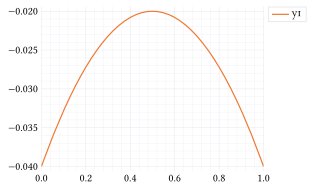

In [48]:
plot(a -> tr(Hint(a)*exp(-β*Hint(a))), xlim=(0, 1))

In [49]:
reshape(diss * vec(ρth), (4, 4))

4×4 Array{Complex{Float64},2}:
          0.0+0.0im           0.0+0.0im  …  -4.03455e-13+0.0im
          0.0+0.0im           0.0+0.0im              0.0+0.0im
          0.0+0.0im  -4.73732e-13+0.0im              0.0+0.0im
 -4.03233e-13+0.0im           0.0+0.0im      5.68434e-14+0.0im

In [50]:
eigen(ρth)

Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
values:
4-element Array{Float64,1}:
 0.24750008333000018
 0.24750008333000018
 0.2524999166699998
 0.2524999166699998
vectors:
4×4 Array{Float64,2}:
  0.0       -0.707107  0.0       0.707107
  0.707107   0.0       0.707107  0.0
 -0.707107   0.0       0.707107  0.0
  0.0        0.707107  0.0       0.707107

The thermal state is a linear combination of eigenmodes which are not necessarily positive (do not admit interpretation as density operators).

In [51]:
vec(ρth)' * vecs[:,end-3:end]

1×4 Adjoint{Complex{Float64},Array{Complex{Float64},1}}:
 2.43455e-17-0.0im  -7.76289e-17-0.0im  -2.67437e-17-0.0im  0.500025-0.0im

In [52]:
diss' - diss .|> abs |> sum

255.99999999998434

In [53]:
disslr' - disslr .|> abs |> sum

255.99999999998272

The LR-part of the dissipator is not Hermitian.

In [54]:
comm(lambham, diss) .|> abs |> sum

8.057665376938247e-12

In [55]:
comm(lambham, dissa) .|> abs |> sum

3.639421096592869e-12

The Lamb-shift and dissipative superoperators commute.

In [56]:
(im*lambham)' - (im*lambham) .|> abs |> sum

0.0

The full Lamb-shift superoperator is Hermitian, as expected.

In [57]:
comm(lambham, disslr) .|> abs |> sum

5.304619880528804e-12

In [58]:
comm(lambham - im*commwith(-0.5*(σx ⊗ₖ σx) - (σz ⊗ₖ σ0 + σ0 ⊗ₖ σz)), diss) .|> abs |> sum

19840.63999573337

In [59]:
Js = vcat(values(Jωs)...);

In [60]:
Ts = [rand(4, 4) for _ in 1:(length(Js) / 2)]
# Ts = (T -> (T + T') / 2).(Ts)
Ts = [Ts; (T -> T').(Ts)];

In [61]:
(Ts -> sum(abs, comm(sum(T -> commwith(T' * T), Ts), sum(T -> leftmul(T) * rightmul(T') - acommwith(T)/2, Ts)))).([Ts, Js])

2-element Array{Float64,1}:
 1691.2295023217935
    8.312762260824573e-14

Since the $\opr{A}_i^\dag \opr{A}_i$ commute with each other:

In [62]:
(Ts -> sum(sum(abs, comm(T1'*T1, T2'*T2)) for T1 in Ts for T2 in Ts))(Js)

2.7533531010703882e-14

But

In [63]:
(Ts -> sum(sum(abs, comm(T1'*T1, T2)) for T1 in Ts for T2 in Ts))(Js)

256.0000000000001

so there must be a different reason why the LR term commutes with the unitary superoperator, as shown here for the Lamb-shift term:

In [64]:
(Ts -> sum(sum(abs, leftmul(T1'*T1*T2)*rightmul(T2') - leftmul(T2)*rightmul(T2'*T1'*T1)
            - leftmul(T2*T1'*T1)*rightmul(T2') + leftmul(T2)*rightmul(T1'*T1*T2'))
        for (T1, T2) in Iterators.product(Ts, Ts)))(Js)

3.6548541970660153e-13

In [65]:
(Ts -> sum(sum(abs, leftmul(T1'*T1*T2)*rightmul(T2') - leftmul(T2)*rightmul(T2'*T1'*T1)
            - leftmul(T2*T1'*T1)*rightmul(T2') + leftmul(T2)*rightmul(T1'*T1*T2'))
        for (T1, T2) in Iterators.product(Ts, Ts)))(Js)

3.6548541970660153e-13

In [66]:
(Ts -> sum(sum(abs, comm(commwith(T1'*T1), leftmul(T2)*rightmul(T2')))
        for (T1, T2) in Iterators.product(Ts, Ts)))(Js)

3.1619151741324463e-13

In [67]:
sum(abs.(lambham*diss - diss*lambham))

8.057665376938247e-12

The system Hamiltonian must be compatible.

In [68]:
ℋx = commwith(σx ⊗ₖ σy)
sum(abs.(ℋx*diss - diss*ℋx))

25984.853327644527

In [69]:
unitary_rates(-g*(σx ⊗ₖ σx) - Sym(1)*(σz ⊗ₖ σ0 + σ0 ⊗ₖ σz), g => 0.5, (ω; kwargs...) -> ω, β = β)

16-element Array{Complex{Float64},1}:
  -7.105427357601002e-15 + 17.46256500261599im
  -5.329070518200751e-15 + 12.731282501307998im
  -9.227884241529766e-16 - 8.000000000000004im
   -4.98851266322101e-16 - 17.462565002615975im
  -3.551676818936971e-16 + 5.018048615358172e-17im
 -1.1092188935359755e-16 + 8.000000000000005im
 -2.0328790734103208e-20 + 12.73128250130797im
   6.809297825563993e-18 - 4.7312825013079856im
  3.2504381131115423e-16 + 4.731282501307987im
  4.1881535493684293e-16 - 2.6582660060945874e-16im
    4.44090998525497e-16 + 4.73128250130799im
   8.925966649376186e-16 - 4.731282501307985im
  1.0009190718918834e-15 - 1.8267373944428236e-16im
  1.0122187765602485e-15 + 1.4434433083475654e-16im
   3.552713678800501e-15 - 12.731282501307987im
   6.862566070964249e-15 - 12.731282501308im

In [70]:
dissipation_rates(-g*(σx ⊗ₖ σx) - Sym(1)*(σz ⊗ₖ σ0 + σ0 ⊗ₖ σz), g => 0.5, γdiv, β = β)

16-element Array{Complex{Float64},1}:
     -3600.2820688037864 + 0.0im
     -3024.7533057095684 + 0.0im
     -2019.4659823157658 + 0.0im
      -2019.465982315764 + 0.0im
     -2005.4659823157656 + 0.0im
     -2005.4659823157656 + 0.0im
     -2000.1099983722622 + 0.0im
     -2000.1099983722602 + 0.0im
     -2000.0833325055642 + 0.0im
     -2000.0833325055637 + 0.0im
     -1994.7273485620638 + 0.0im
     -1994.7273485620617 + 0.0im
     -1980.7273485620644 + 0.0im
     -1980.7273485620588 + 0.0im
      -1375.351287242299 + 0.0im
 -1.4432293251112616e-12 + 0.0im

## Dissipator eigenvalue plots

In [71]:
rubric = RGB(0.7, 0.05, 0.0);

In [264]:
"`entropy(H, β)` is the entropy of the thermal state in bits."
function entropy(H, β)
    Es = eigvals(H)
    Z = sum(exp(-β*E) for E in Es)
    Ps = [exp(-β*E) / Z for E in Es]
    -sum(iszero(P) ? zero(P) : P*log2(P) for P in Ps)
end

function energyvariance(H, β)
    Es = eigvals(H)
    Z = sum(exp(-β*E) for E in Es)
    Ps = [exp(-β*E) / Z for E in Es]
    H1 = sum(E*P for (E, P) in zip(Es, Ps))
    H2 = sum(E^2*P for (E, P) in zip(Es, Ps))
    H2 - H1^2
end;

function ηenergyvariance(H, η)
    Es = eigvals(H) / η
    Z = sum(exp(-E) for E in Es)
    Ps = [exp(-E) / Z for E in Es]
    H1 = sum(E * P for (E, P) in zip(Es, Ps))
    H2 = sum(E^2 * P for (E, P) in zip(Es, Ps))
    H2 - H1^2
end;

We map $E \mapsto E / \eta$ so that $\eta$ is a dimensionless inverse temperature $\beta$.

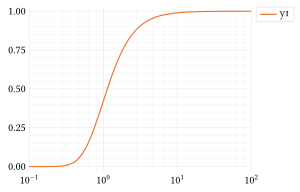

In [280]:
plot(T -> energyvariance(Hx, 1/T), xlim=(1e-1, 1e2), xscale=:log10)

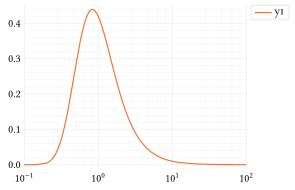

In [270]:
plot(η -> ηenergyvariance(Hx, η), xlim=(1e-1, 1e2), xscale=:log10)

In [279]:
using Roots

In [647]:
interpscale(g) = √(8*(g - 1/2)^2 + 2)

trnorm(A) = √(tr(A'*A))
trnormalize(A) = A / trnorm(A)
∠(A, B) = acos(trnorm(trnormalize(A)' * trnormalize(B)))
function slerp(A, B, g)
    θ = ∠(A, B)
    (sin((1-g)*θ)*A + sin(g*θ)*B) / sin(θ)
end

# Requirement: `normslerp` must not change the reference Hamiltonian.
function normslerp(A, B, g)
    C = slerp(A, B, g)
    C /= trnorm(C)
end
# normslerp(H1, H2, g) = ((1-g)*H1 + √(2)*g*H2) #/ interpscale(g)

Hint0(g) = normslerp(trnormalize(-Hx), trnormalize(-Hz), g)

# Is this confused between A and η?
Ainvar(g, η) = find_zero(A -> ηenergyvariance(Hint0(0), η) - ηenergyvariance(A*Hint0(g), η), η)
# Ainvar(g, β) = 1
Hint(g, η) = Ainvar(g, η) * Hint0(g)

function plot_varrel_rates(g0s, β; kwargs...)
    η = β
    β = 1
    H(g) = Hint(g, η)
    rates_ising = [real(dissipation_rates(H(g), γdiv, β = β)) for g in g0s]
    rates_free_ising = real(dissipation_rates(H(0), γdiv, β = β))[1:end-1];
    rates_free_trans = real(dissipation_rates(H(1), γdiv, β = β))[1:end-1];

    plot(g0s, -hcat(rates_ising...)'[:,1:end-1],
        title=L"\eta = %$η",
        xlabel="Relative angle",
        color=:black,
        alpha=0.25;
        kwargs...)

    scatter!(repeat([g0s[1] - 2e-2], length(rates_free_ising)), -rates_free_ising,
        marker=(:rtriangle, 2, rubric),
        markerstrokecolor=rubric
    )
    scatter!(repeat([g0s[end] + 2e-2], length(rates_free_trans)), -rates_free_trans,
        marker=(:ltriangle, 2, rubric),
        markerstrokecolor=rubric
    )
end

function plot_η_rates(η0s, g; kwargs...)
    rates = [real(dissipation_rates(Hint(g, η), γdiv, β = 1)) for η in η0s]
    plot(η0s, -hcat(rates...)'[:,1:end-1],
        title=L"g = %$g",
        xlabel=L"\eta",
        color=:black,
        alpha=0.25;
        kwargs...)
end;

In [632]:
import Plots.PlotMeasures: pt;

function rate_plot(g0s, βs, f; kwargs...)
    cols = 3
    width = 800
    s = width // cols
    d = length(βs) // cols
    plot([f(g0s, β) for β in βs]...,
        layout=(:, cols),
        size=(width, s*d),
        ylabel="Nonzero dissipator eigenvalues (negated)",
        top_margin=6pt,
        bottom_margin=6pt,
        yscale=:log10,
        key=false;
        kwargs...
    )
end;

In [636]:
g0s = 10 .^ range(-2, 1, length=64)
η0s = 10 .^ range(-1, 1.5, length=128)
βs = [1e-1, 2e-1, 5e-1, 1e0, 2e0, 5e0, 1e1, 2e1, 5e1];

TODO: Why are the rates not constant over $\eta$? Heat capacity issue at low/high temperatures?

**Cause:** `Ainvar` at low $\eta$ is not 1, but should always be 1 for $g = 0$ (reference).

TODO: Make one plot against $g$, since nondim. diss. don't change with $\eta$ (for $A = 1$)? For `Ainvar`?

(This is just the last grid `rate_plot`). What happens to zero-tending eigenvalues?

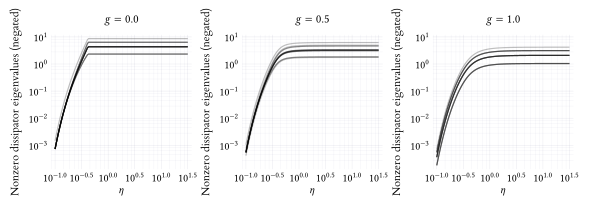

In [637]:
rate_plot(η0s, [0, 0.5, 1], plot_η_rates, link=:all, xscale=:log10)

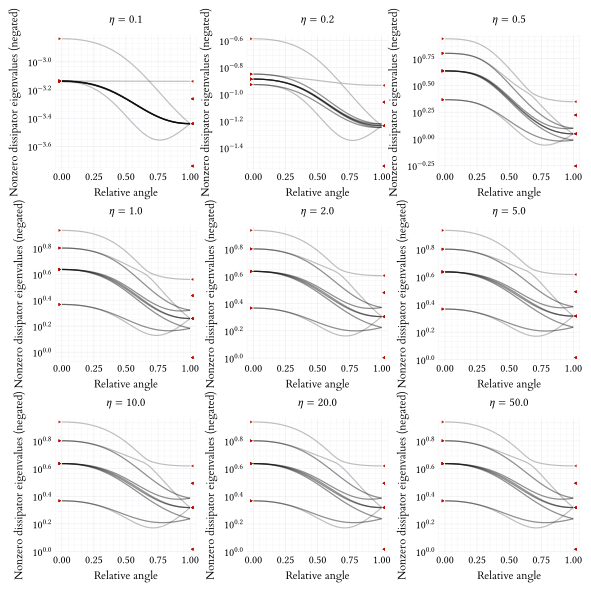

In [638]:
rate_plot(range(1e-3, 1-1e-3, length=64), βs, plot_varrel_rates)

Now look at the unnormalized interpolation.

In [76]:
lgs = range(1e-3, 1-1e-3, length=64)
energies = [eigvals(((1 - g)*Hx/trnorm(Hx) + √(2)*g*Hz/trnorm(Hz)) / interpscale(g)) for g in lgs]
Hnorms = [trnorm2(((1 - g)*Hx/trnorm(Hx) + √(2)*g*Hz/trnorm(Hz)) / interpscale(g)) for g in lgs]
energydifferences = [[x - y for (x, y) in Iterators.product(Es, Es)] for Es in energies];

In [492]:
energies = [eigvals(Hint(g, 1e0)) for g in lgs];

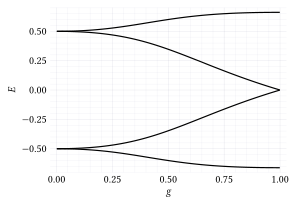

In [493]:
plot(lgs, hcat(energies...)', color=:black, key=false, xlabel=L"g", ylabel=L"E")

In [81]:
# https://github.com/JuliaDiff/ForwardDiff.jl/issues/111#issuecomment-638251496
import ForwardDiff: Dual
import LinearAlgebra: eigvals

function LinearAlgebra.eigvals(A::Symmetric{<:Dual{Tg,T,N}}) where {Tg,T<:Real,N}
    λ,Q = eigen(Symmetric(getproperty.(parent(A), :value)))
    partials = ntuple(j -> diag(Q' * getindex.(getproperty.(A, :partials), j) * Q), N)
    Dual{Tg}.(λ, tuple.(partials...))
end;

TODO: Fix eigvals redefinition issue

In [82]:
Hlerp(g) = (1-g)*trnormalize(Hx) + g*trnormalize(Hz)
lerpEs(g) = eigvals(Symmetric(Hlerp(g)));

In [489]:
# This hangs:
# derivative(g -> eigvals(Symmetric(Hlerp(g))), 0.5)

In [99]:
import ForwardDiff: derivative
derivative(f) = x -> derivative(f, x);

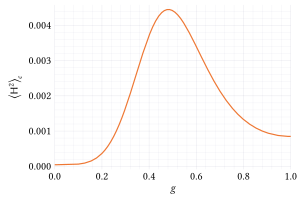

In [140]:
plot(g -> energyvariance(normslerp(trnormalize(Hx), trnormalize(Hz), g, βA), βA),
    xlim=(0, 1),
    xlabel=L"g",
    ylabel=L"\ev{\ham^2}_c",
    key=false,
)

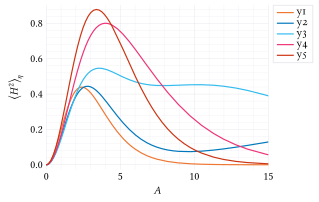

In [308]:
β0 = 1e0
η0 = 1e0
plot([A -> ηenergyvariance(A*Hint0(g), η0) for g in 0:0.25:1], xlim=(0, 15*η0), xlabel=L"A", ylabel=L"\ev{H^2}_\eta")

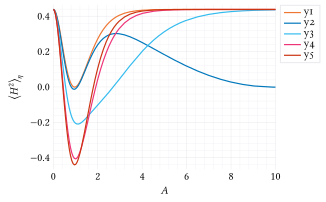

In [402]:
β0 = 1e0
η0 = 2e-1
# plot([A -> ηenergyvariance(A*Hint0(g), η0) for g in 0:0.25:1], xlim=(0, 15*η0), xlabel=L"A", ylabel=L"\ev{H^2}_\eta")
plot([A -> ηenergyvariance(Hint0(0), η0) - ηenergyvariance(A*Hint0(g), η0) for g in 0:0.25:1], xlim=(0, 50*η0), xlabel=L"A", ylabel=L"\ev{H^2}_\eta")

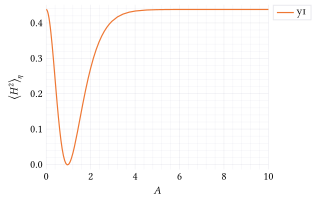

In [408]:
plot(A -> ηenergyvariance(Hint0(0), η0) - ηenergyvariance(A*Hint0(2e-2), η0), xlim=(0, 50*η0), xlabel=L"A", ylabel=L"\ev{H^2}_\eta")

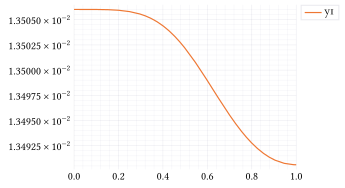

In [474]:
η0 = 1e-1
plot(g -> find_zeros(A -> ηenergyvariance(Hint0(0), η0) - ηenergyvariance(A*Hint0(g), η0), 0, 1)[1], xlim=(0, 1))

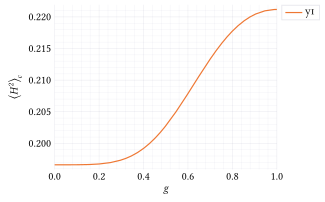

In [475]:
plot(g -> energyvariance(Hint(g), β0), xlim=(0, 1), xlabel=L"g", ylabel=L"\ev{H^2}_c")

┌ Warning: No strict ticks found
└ @ PlotUtils /home/jfjhh/.julia/packages/PlotUtils/es5pb/src/ticks.jl:283


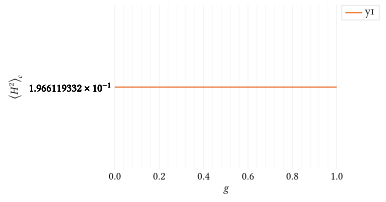

In [476]:
plot(g -> energyvariance(Ainvar(g, β0)*Hint(g), β0), xlim=(0, 1), xlabel=L"g", ylabel=L"\ev{H^2}_c")

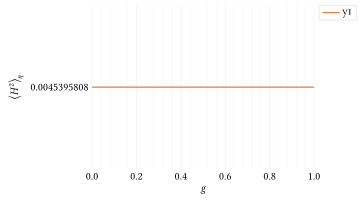

In [477]:
plot(g -> ηenergyvariance(Hint(g, η0), η0), xlim=(0, 1), xlabel=L"g", ylabel=L"\ev{H^2}_\eta")

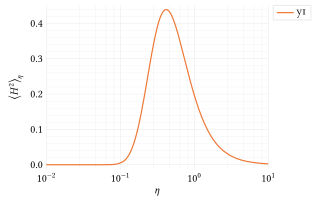

In [478]:
plot(η -> ηenergyvariance(Hint(0, η), η), xlim=(1e-2, 1e1), xscale=:log10, xlabel=L"\eta", ylabel=L"\ev{H^2}_\eta")

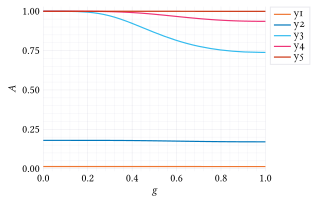

In [479]:
plot([g -> Ainvar(g, η) for η in [1e-1, 2e-1, 5e-1, 1e0, 1e1]], xlim=(0, 1),
    xlabel=L"g",
    ylabel=L"A",
)

TODO: `Ainvar` for $g = 0$ should always be 1.

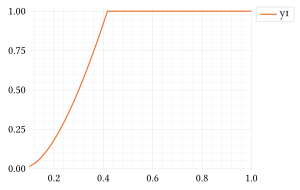

In [648]:
plot(η -> Ainvar(0, η), xlim=(1e-1, 1))